### Data Importation

In [1]:
import pandas as pd
train_df = pd.read_csv('/content/train_dataset.csv')
test_df = pd.read_csv('/content/test_dataset.csv')
validation_df = pd.read_csv('/content/valid_dataset.csv')

In [3]:
train_df.columns

Index(['text', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

### **Data preparation**

In [2]:
import numpy as np
MAX_LENGTH = 64
X_train_input_ids = np.zeros((len(train_df), MAX_LENGTH))
X_train_attn_masks = np.zeros((len(train_df), MAX_LENGTH))

X_test_input_ids = np.zeros((len(test_df), MAX_LENGTH))
X_test_attn_masks = np.zeros((len(test_df), MAX_LENGTH))

X_validation_input_ids = np.zeros((len(validation_df), MAX_LENGTH))
X_validation_attn_masks = np.zeros((len(validation_df), MAX_LENGTH))

In [3]:
from tqdm import tqdm

def generate_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [4]:
!pip install transformers -q
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("aubmindlab/bert-large-arabertv02-twitter")

In [5]:
X_train_input_ids, X_train_attn_masks = generate_data(train_df, X_train_input_ids, X_train_attn_masks, tokenizer) 

X_test_input_ids, X_test_attn_masks = generate_data(test_df, X_test_input_ids, X_test_attn_masks, tokenizer) 

X_validation_input_ids, X_validation_attn_masks = generate_data(validation_df, X_validation_input_ids, X_validation_attn_masks, tokenizer) 

2257it [00:04, 453.65it/s] 
1507it [00:00, 2500.05it/s]
580it [00:00, 2515.27it/s]


In [ ]:
X_train_input_ids

array([[2.0000e+00, 1.8440e+03, 8.8000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 4.5900e+02, 2.4276e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.9031e+04, 2.7083e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 1.9550e+03, 7.2410e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.2949e+04, 6.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 1.6038e+04, 2.0900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [6]:
train_labels = np.zeros((len(train_df), 11))
test_labels = np.zeros((len(test_df), 11))
validation_labels = np.zeros((len(validation_df), 11))

In [7]:
labels_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']  
train_labels = train_df[labels_names].values.astype('int8')
test_labels = test_df[labels_names].values.astype('int8')
validation_labels = validation_df[labels_names].values.astype('int8')

In [ ]:
train_labels

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int8)

In [8]:
import tensorflow as tf
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_attn_masks, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation_input_ids, X_validation_attn_masks, validation_labels))

In [9]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) # batch size, drop any left out tensor
validation_dataset = validation_dataset.map(SentimentDatasetMapFunction)
validation_dataset = validation_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=False)

### **Model**

In [11]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained("aubmindlab/bert-large-arabertv02-twitter", from_pt=True) # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

In [12]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

In [13]:
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
# base = model.bert(input_ids, attention_mask=attn_masks)
# bert_embds = base.pooler_output

In [14]:
intermediate_layer = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(11, activation='sigmoid', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

In [15]:
emotion_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
emotion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  369423360   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

### **Train**

Without scheduler

In [16]:
optim = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_func = tf.keras.losses.BinaryCrossentropy()

In [17]:
emotion_model.compile(optimizer=optim, loss=loss_func)

with early stopping

In [18]:
NUM_EPOCHS = 20

# Define the early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
  history = emotion_model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=NUM_EPOCHS,
      callbacks=[early_stopping_callback]
  )

Epoch 1/20
70/70 [==============================] - 206s 1s/step - loss: 0.3940 - val_loss: 0.3011
Epoch 2/20
70/70 [==============================] - 98s 1s/step - loss: 0.2668 - val_loss: 0.2693
Epoch 3/20
70/70 [==============================] - 95s 1s/step - loss: 0.2201 - val_loss: 0.2633
Epoch 4/20
70/70 [==============================] - 95s 1s/step - loss: 0.1865 - val_loss: 0.2614
Epoch 5/20
70/70 [==============================] - 95s 1s/step - loss: 0.1596 - val_loss: 0.2669
Epoch 6/20
70/70 [==============================] - 95s 1s/step - loss: 0.1317 - val_loss: 0.2712
Epoch 7/20
70/70 [==============================] - 95s 1s/step - loss: 0.1079 - val_loss: 0.2772


In [19]:
from sklearn.metrics import jaccard_score

# Generate predictions on test set
test_preds = emotion_model.predict([X_test_input_ids, X_test_attn_masks])
test_preds[test_preds >= 0.5] = 1
test_preds[test_preds < 0.5] = 0

48/48 [==============================] - 28s 438ms/step


In [20]:
# Compute Jaccard index
jaccard_index = jaccard_score(test_labels, test_preds, average='weighted')

print('Jaccard index:', jaccard_index)

Jaccard index: 0.5612256211670127


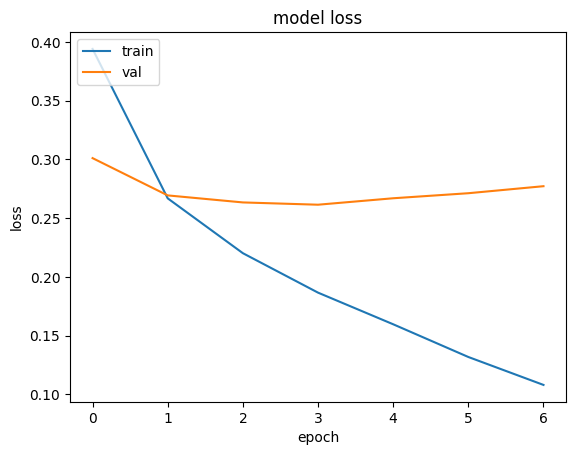

In [21]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Save the model as an H5 file
emotion_model.save('emotion_model.h5')

In [28]:
import numpy as np

# Define Arabic text examples
arabic_examples = [
    'أنا سعيد جدًا بالنجاح الذي حققته في عملي، وأشعر بالتفاؤل للمستقبل.',
    'أشعر بالخوف والحزن بسبب الوضع الراهن والتحديات التي نواجهها.',
    'لم يكن العمل بالنسبة لي مجرد وظيفة، بل كان يمثل شغفي وحبي.',
    'شعرت بالاشمئزاز من تصرفات بعض الأشخاص وسلوكهم السيء.',
    'أنا متحمس للاحتفال بعيد ميلادي الذي سيحل قريبًا وأشعر بالفرحة.',
    'أنا أحب عائلتي وأقدر الحب الذي يبادلوني إياه.',
    'كنت مترددًا في بداية الأمر لكني الآن أشعر بالثقة والتفاؤل لتحقيق الهدف.',
    'أشعر بالغضب بسبب الظلم الذي يتعرض له بعض الأفراد في المجتمع.',
    'شعرت بالدهشة عندما سمعت الخبر السار والذي لم أكن أتوقعه.',
    'أنا متأكد من صدق ووفاء صديقي العزيز وأشعر بالثقة تجاهه.'
]

# Loop through Arabic examples and make predictions
for i, text in enumerate(arabic_examples):
    # Tokenize input sentence
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=64, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )

    # Get input_ids and attention_mask from tokenized text
    input_ids = tokenized_text.input_ids
    attention_mask = tokenized_text.attention_mask

    # Make predictions on tokenized input
    preds = emotion_model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Convert probabilities to binary predictions
    binary_preds = (preds >= 0.5).astype(int)

    # Get predicted labels
    predicted_labels = np.array(labels_names)[binary_preds[0] == 1]

    # Print predicted labels and expected labels for each example
    print('Example {}:'.format(i+1))
    print('Input Text: {}'.format(text))
    print('Predicted Labels: {}'.format(predicted_labels))

1/1 [==============================] - 0s 119ms/step
Example 1:
Input Text: أنا سعيد جدًا بالنجاح الذي حققته في عملي، وأشعر بالتفاؤل للمستقبل.
Predicted Labels: ['joy' 'optimism']
1/1 [==============================] - 0s 120ms/step
Example 2:
Input Text: أشعر بالخوف والحزن بسبب الوضع الراهن والتحديات التي نواجهها.
Predicted Labels: ['fear' 'sadness']
1/1 [==============================] - 0s 128ms/step
Example 3:
Input Text: لم يكن العمل بالنسبة لي مجرد وظيفة، بل كان يمثل شغفي وحبي.
Predicted Labels: ['love' 'trust']
1/1 [==============================] - 0s 99ms/step
Example 4:
Input Text: شعرت بالاشمئزاز من تصرفات بعض الأشخاص وسلوكهم السيء.
Predicted Labels: ['anger' 'disgust' 'pessimism' 'sadness']
1/1 [==============================] - 0s 135ms/step
Example 5:
Input Text: أنا متحمس للاحتفال بعيد ميلادي الذي سيحل قريبًا وأشعر بالفرحة.
Predicted Labels: ['joy' 'love' 'optimism']
1/1 [==============================] - 0s 169ms/step
Example 6:
Input Text: أنا أحب عائلتي وأقدر الحب الذ